In [1]:
import os, sys, time, random
import h5py
import numpy as np
import unicodedata as u

In [2]:
from keras.layers import *
from keras.models import *
from keras.utils import *
from keras.initializers import *
import tensorflow as tf
from keras.preprocessing.sequence import *

2023-05-21 00:43:21.276368: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 00:43:21.772902: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 00:43:21.793232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-21 00:43:21.793325: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path_train = "../data/ko_kaist-ud-dev.conllu"

In [4]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path_train, 'r', encoding='utf-8') as f:
    for line in f.readlines():
        if line[0].isdigit():
            split = line.strip().split("\t")
            input_text = split[1]
            target_text = split[2]
            target_text = '\t' + target_text + '\n'
            input_texts.append(input_text)
            target_texts.append(target_text)
            for char in input_text:
                if char not in input_characters:
                    input_characters.add(char)
            for char in target_text:
                if char not in target_characters:
                    target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [5]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 25278
Number of unique input tokens: 1077
Number of unique output tokens: 1020
Max sequence length for inputs: 17
Max sequence length for outputs: 20


In [6]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [7]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

2023-05-21 00:43:31.186202: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-21 00:43:31.186426: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-21 00:43:31.186571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-3P0J615): /proc/driver/nvidia/version does not exist
2023-05-21 00:43:31.187760: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.summary()
# print(model.layers[-1].input)
print(model.layers[-3].output)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 1077)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 1020)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                    [(None, 256),        1366016     ['input_1[0][0]']                
                                 (None, 256),                                                 

In [9]:
print("encoder_input_data shape:",encoder_input_data.shape)
print("decoder_input_data shape:",decoder_input_data.shape)
print("decoder_target_data shape:",decoder_target_data.shape)

encoder_input_data shape: (25278, 17, 1077)
decoder_input_data shape: (25278, 20, 1020)
decoder_target_data shape: (25278, 20, 1020)


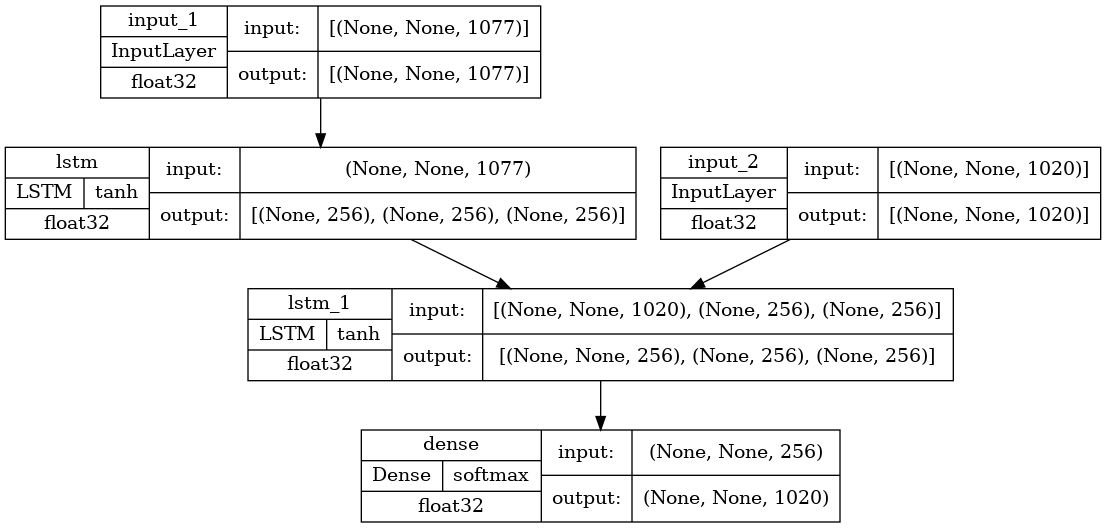

In [10]:
plot_model(model,show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [11]:
# Run training
from keras.optimizers import * 
model.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.001), loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs, 
          validation_split=0.2)
model.save('../models/model_generation.h5') 

Epoch 1/10
316/316 [==============================] - 85s 244ms/step - loss: 1.0450 - val_loss: 0.9701
Epoch 2/10
316/316 [==============================] - 65s 205ms/step - loss: 0.8953 - val_loss: 0.7919
Epoch 3/10
316/316 [==============================] - 63s 201ms/step - loss: 0.7050 - val_loss: 0.6990
Epoch 4/10
316/316 [==============================] - 63s 200ms/step - loss: 0.5839 - val_loss: 0.6041
Epoch 5/10
316/316 [==============================] - 64s 202ms/step - loss: 0.5697 - val_loss: 0.6341
Epoch 6/10
316/316 [==============================] - 64s 202ms/step - loss: 0.5394 - val_loss: 0.5825
Epoch 7/10
316/316 [==============================] - 64s 203ms/step - loss: 0.4526 - val_loss: 0.5043
Epoch 8/10
316/316 [==============================] - 64s 203ms/step - loss: 0.3988 - val_loss: 0.4719
Epoch 9/10
316/316 [==============================] - 63s 200ms/step - loss: 0.3649 - val_loss: 0.4456
Epoch 10/10
316/316 [==============================] - 65s 204ms/step - l

## Test

In [12]:
# Define sampling models
model = tf.keras.models.load_model('../models/model_generation.h5')
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [13]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.
    
      # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
            
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [14]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 50ms/step
-
Input sentence: 내
Decoded sentence: 내

1/1 [==============================] - 0s 60ms/step
-
Input sentence: 고향은
Decoded sentence: 지식+을

1/1 [==============================] - 0s 52ms/step
-
Input sentence: 서울입니다
Decoded sentence: 서울+이+이+다

1/1 [==============================] - 0s 57ms/step
-
Input sentence: .
Decoded sentence: .

1/1 [==============================] - 0s 49ms/step
-
Input sentence: 옛날의
Decoded sentence: 옛+는

1/1 [==============================] - 0s 54ms/step
-
Input sentence: 서울의
Decoded sentence: 서울+의

1/1 [==============================] - 0s 45ms/step
-
Input sentence: 모습이
Decoded sentence: 모이+다

1/1 [==============================] - 0s 64ms/step
-
Input sentence: 몹시
Decoded sentence: 점시

1/1 [==============================] - 0s 61ms/step
-
Input sentence: 그립습니다
Decoded sentence: 그러+으로+는

1/1 [==============================] - 0s 48ms/step
-
Input sentence: .
Decoded sentence: .

1/1 [=======================